In [26]:
####################################################################
# Steps for the final design of QbH (TVD+Semi-global)
# 1. Transcribe all MIDI songs, and generate a 2D matrix
# 2. Select the set of queries
# 3. Run a loop: each iteration, send a query and get its rank
# 4. At the end of the loop, compute MRR

In [27]:
import sys
import os
import seaborn as sds
import pretty_midi
import librosa.display
import numpy as np, scipy, scipy.spatial, matplotlib.pyplot as plt
from align import aligner
from align.matrix import DNAFULL
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from numpy import diff
from six.moves import xrange
from skimage.restoration import denoise_wavelet, denoise_tv_chambolle
from scipy.signal import find_peaks

sds.set()
plt.rcParams['figure.figsize'] = (20, 15)
#%matplotlib inline

In [32]:
# Run a LOOP to transcribe all the MIDI files in the dataset and store in a 2D ARRAY

# List all files in a directory using os.listdir
basepath = 'audio/train/'

# create a 2D array with np empty()
pitchvalue = np.zeros((48, 250000)) # assuming that length of a song does not exceed 500s ~ 8min

#n = len(querypitch)
print('MIDI transcription begins: extracting note sequence of 48 MIDI songs')
for data in os.listdir(basepath):
    if data.endswith('.mid'):
        # data is a string, eg, "00001.mid". we want 00001 so we split.
        entry = data.split(".")
        # counter for row number of the 2D array
        # Load MIDI file into PrettyMIDI object
        midifile = pretty_midi.PrettyMIDI(basepath + data)
        for i in range(len(midifile.instruments)):
            # Construct a PrettyMIDI object.
            # We'll specify that it will have a tempo of 80bpm.
            #pm = pretty_midi.PrettyMIDI(initial_tempo=80)
            # if(len(midifile.instruments[i].pitch_bends) == 0):
                #print(entry[0] + '.mid'+ ' is being sampled')
                #print(midifile.instruments[i].notes)
                #print(midifile.instruments[i].pitch_bends)
                #print(len(midifile.instruments[i].pitch_bends))

                # sampling rate r of MIDI should be the same as SR of query 
                # length of each query = 8s and n = length of querypitch vector
                #r = 8/n 
                k = 0 # counter for array pitchvalue
                t = 0.007*k # to keep time (discretization of the notes has been done at intervals of 2 ms)
                for j in range(len(midifile.instruments[i].notes)):
                    start = midifile.instruments[i].notes[j].start
                    #print(start)
                    end = midifile.instruments[i].notes[j].end
                    pitch = midifile.instruments[i].notes[j].pitch
                    t = start
                    while t >= start and t <= end:
                        k = int(t/0.007)
                        pitchvalue[int(entry[0])-1][k] = pitch
                        #print(pitch)
                        t += 0.007


print("End of Step: MIDI transcription")
print("...................................................................")

MIDI transcription begins: extracting note sequence of 48 MIDI songs


FileNotFoundError: [Errno 2] No such file or directory: '../audio/train/'

In [29]:
def QbH_denoised(testpath) :
    
    ##################### Loading audio ###########################################################################################################
    querypitch = np.genfromtxt(testpath, filling_values=0)
    querypitch = np.trim_zeros(querypitch)

    #print("Length of query with time information = " + str(len(querypitch)))

    for i in range(len(querypitch)):
        if querypitch[i] == 0 :
            querypitch[i] = querypitch[i-1]

    #################### TVD ###########################################################################################################
    ecg_skimage = denoise_tv_chambolle(querypitch, weight=5, eps=0.00009, n_iter_max=5000, multichannel=False)
    #plt.plot(ecg_skimage)
    #plt.show()
    
    #################### Pitch smoothening ##########################################################################################################
    dy = np.diff(ecg_skimage)
    #plt.plot(dy)
    #plt.show()
    
    stdev = np.std(dy)
    #print(stdev)

    for i in range(len(dy)):
        diff = dy[i] - np.mean(dy)
        if np.absolute(diff) < stdev:
            dy[i] = 0

    #plt.plot(dy)
    #plt.show()
    
    dyabs = np.absolute(dy)
    peaks, _ = find_peaks(dyabs) # peaks stores the indices of peaks
    #k = 0
    #plt.plot(peaks, dyabs[peaks], 'xb-')
    #plt.show()

    ddy = np.zeros(len(dyabs[peaks]))
    dy_corrected = np.copy(dy)

    for i in range(1, len(peaks)) :
        y = dyabs[peaks[i]] - dyabs[peaks[i-1]]
        x = (peaks[i] - peaks[i-1] ) / 25.0 #/25.0 # divide by 25 for equal x, y scales
        tan = np.arctan(np.abs(ddy))
        if x != 0 :
            ddy[i] = y/x

        tan = np.degrees(np.arctan(np.abs(ddy[i])))
        #print("slope= " + str(ddy[i]))
        #print(" tan= " + str(tan))
        if tan > 80 :
            minimum = min(dyabs[peaks[i]], dyabs[peaks[i-1]])
            minidx = 0
            if dyabs[peaks[i]] == minimum : 
                minidx = peaks[i]
            else :
                minidx = peaks[i-1]
            #print(peaks[i], peaks[i-1], minidx)
            dy_corrected[minidx] = 0
    #print(dy_corrected)
    #plt.plot(dy_corrected)
    #plt.show()
    
    #################### RECONSTRUCTING THE QUERY PITCH VECTOR ###################################################
    #plt.plot(dy_corrected)
    #plt.show()
    peaks1, _ = find_peaks(np.abs(dy_corrected))
    #plt.plot(peaks1, dy_corrected[peaks1], "x")
    #plt.xlim(0, 250)
    #plt.show()

    for i in range(1, len(ecg_skimage)):
        if (i in peaks1) and (i != len(ecg_skimage)-1) :
            ecg_skimage[i] = ecg_skimage[i+1]
        else :
            ecg_skimage[i] = ecg_skimage[i-1]

    #plt.plot(ecg_skimage)
    #plt.show()
    
    querypitch = ecg_skimage
    querypitch = np.pad(querypitch, (0, 250 - len(querypitch)), 'constant', constant_values=(0, 0)) 
    return querypitch
    
"""    
    ## Generating Parson'sCode of Query
    queryparson = ["A"] * len(querypitch)
    for j in range(1, len(querypitch)):
        diff = querypitch[j] - querypitch[j-1]
        if diff > 0 :
            queryparson[j-1] = "A"
        if diff < 0 :
            queryparson[j-1] = "C"
        if diff == 0 : 
            queryparson[j-1] = "G"

    #print("Query with time information = ") 
    #print(queryparson)

    n = len(queryparson)  
    # k is used to store index of result  
    # string (or index of current distinct  
    # character)  
    k = 0
    # Traversing string  
    for i in range(1, n):  
        if queryparson[i] != 'G' :
            k += 1
            queryparson[k] = queryparson[i]
        # If current character S[i]  
        # is different from S[k]  
        elif (queryparson[k] != queryparson[i]): 
            k += 1
            queryparson[k] = queryparson[i]  

    # Putting string termination  
    # character.  
    k += 1
    queryparson = queryparson[:k] 

    #print("Length of query without time information = " + str(len(queryparson)))
    #print("Query without time information = ") 
    #print(queryparson)   
    
    score = np.zeros(48)
    #midispan = np.zeros(48)
    #gap = np.zeros(48)
    #midistrlength = np.zeros(48)

    for i in range(0, 48):
        #print("MIDI song number being processed is: " + str(i+1))

        # Changing the i-th pitch vector of the MIDI files ( pitchvalue[i] ) into successively relative notes
        relativepitchvalue = np.trim_zeros(pitchvalue[i])
        #print(relativepitchvalue)
        midiparson = ["A"] * len(relativepitchvalue) 
        # U = A
        # D = C
        # S = G
        #print(len(relativepitchvalue2))

        # ************* Step i ***************
        # For each midi, Generate Parson Code
        # ************************************

        for j in range(1, len(relativepitchvalue)):
            diff = relativepitchvalue[j] - relativepitchvalue[j-1]
            #print(diff)
            if diff > 0 :
                midiparson[j-1] = "A"
            if diff < 0 :
                midiparson[j-1] = "C"
            if diff == 0 : 
                midiparson[j-1] = "G"

        #print("Length of midi with time information = " + str(len(midiparson))) 

        # **************** Step ii *******************
        # For each midi, remove duplicate characters
        # ********************************************

        n1 = len(midiparson)   
        # k is used to store index of result string (or index of current distinct character)  
        k1 = 0    
        # Traversing string  
        for m in range(1, n1):    
            if midiparson[m] != 'G' :
                k1 += 1
                midiparson[k1] = midiparson[m]  
            # If current character S[m]  
            # is different from S[k1]  
            elif (midiparson[k1] != midiparson[m]) : 
                k1 += 1
                midiparson[k1] = midiparson[m]  

        # Putting string termination  
        # character.  
        k1 += 1
        midiparson = midiparson[:k1] 

        #######################################################################
        # Convert midiparson, queryparson from list to string for the alignment
        #######################################################################
        querystring = "".join(map(str, queryparson))
        midistring = "".join(map(str, midiparson))

        #print(" Length of midi without time information = " + str(len(midiparson)))  
        #midistrlength[i] = len(midiparson)

        p = aligner(querystring, midistring[:(len(querystring)+10)], method='glocal', gap_open=-10, gap_extend=-2) # , gap_open=-8, gap_extend=-1
        #midispan[i] = p[0][5] - p[0][3]
        #gap[i] = np.abs(p[0][6] - p[0][7])
        score[i] = p[0][9]
        #print("query "+ str(p[0][0]))
        #print(p)
        
    sorted_score = np.sort(-score)
    sorted_score = -np.unique(sorted_score) # to remove repeated scores
    #print(sorted_score)
    #print(score[songno-1])
    # Now we find out what is the score of the desired midi 
    rank = 1 + np.where(sorted_score == score[songno-1])[0]
    #print(np.where(sorted_score == score[songno-1]))
    print(testpath + " " + str(rank))
    return rank

######################## End of QbH for this query ######################################################################################################################
"""

'    \n    ## Generating Parson\'sCode of Query\n    queryparson = ["A"] * len(querypitch)\n    for j in range(1, len(querypitch)):\n        diff = querypitch[j] - querypitch[j-1]\n        if diff > 0 :\n            queryparson[j-1] = "A"\n        if diff < 0 :\n            queryparson[j-1] = "C"\n        if diff == 0 : \n            queryparson[j-1] = "G"\n\n    #print("Query with time information = ") \n    #print(queryparson)\n\n    n = len(queryparson)  \n    # k is used to store index of result  \n    # string (or index of current distinct  \n    # character)  \n    k = 0\n    # Traversing string  \n    for i in range(1, n):  \n        if queryparson[i] != \'G\' :\n            k += 1\n            queryparson[k] = queryparson[i]\n        # If current character S[i]  \n        # is different from S[k]  \n        elif (queryparson[k] != queryparson[i]): \n            k += 1\n            queryparson[k] = queryparson[i]  \n\n    # Putting string termination  \n    # character.  \n    k

In [30]:
# Load the path to queries, "querypath"

querypath = 'audio/test/'
db_x = np.zeros((4500, 250)) # no. of queries to extract
db_y = np.zeros(4500) # label corresponding to each query
db_counter = 0 # counter to access (read/write) db

for year in os.listdir(querypath) :
    if os.path.isdir(os.path.join(querypath, year)) :
        print(os.path.join(querypath, year))
        for person in os.listdir(os.path.join(querypath, year)) :
            if os.path.isdir(os.path.join(querypath, year, person)) :
                for song in os.listdir(os.path.join(querypath, year, person)) :
                    if (song.endswith('.pv')) :
                        db_y[db_counter] = int((song.split("."))[0])
                        singlesong_path = querypath + year + "/" + person + "/" + song
                        db_x[db_counter] = QbH_denoised(singlesong_path)
                        db_counter += 1

"""    
    if qname.endswith('.pv') :
        songno = int((qname.split("."))[0])
        
        path = querypath + qname
        k = QbH(songno, path, pitchvalue)
        rank[c] = 1.0/k # to simplify MRR caluclation
        c += 1

# Compute MRR
l = len(np.trim_zeros(rank))
mrr = (1.0/l)*(np.sum(np.trim_zeros(rank)))
mrr = round(mrr, 3)
print("MRR= "+ str(mrr))
"""

audio/test/year2006a
audio/test/year2008
audio/test/year2009
audio/test/year2004b
audio/test/year2007
audio/test/year2006b
audio/test/year2005
audio/test/year2004a
audio/test/year2003


'    \n    if qname.endswith(\'.pv\') :\n        songno = int((qname.split("."))[0])\n        \n        path = querypath + qname\n        k = QbH(songno, path, pitchvalue)\n        rank[c] = 1.0/k # to simplify MRR caluclation\n        c += 1\n\n# Compute MRR\nl = len(np.trim_zeros(rank))\nmrr = (1.0/l)*(np.sum(np.trim_zeros(rank)))\nmrr = round(mrr, 3)\nprint("MRR= "+ str(mrr))\n'

31.0


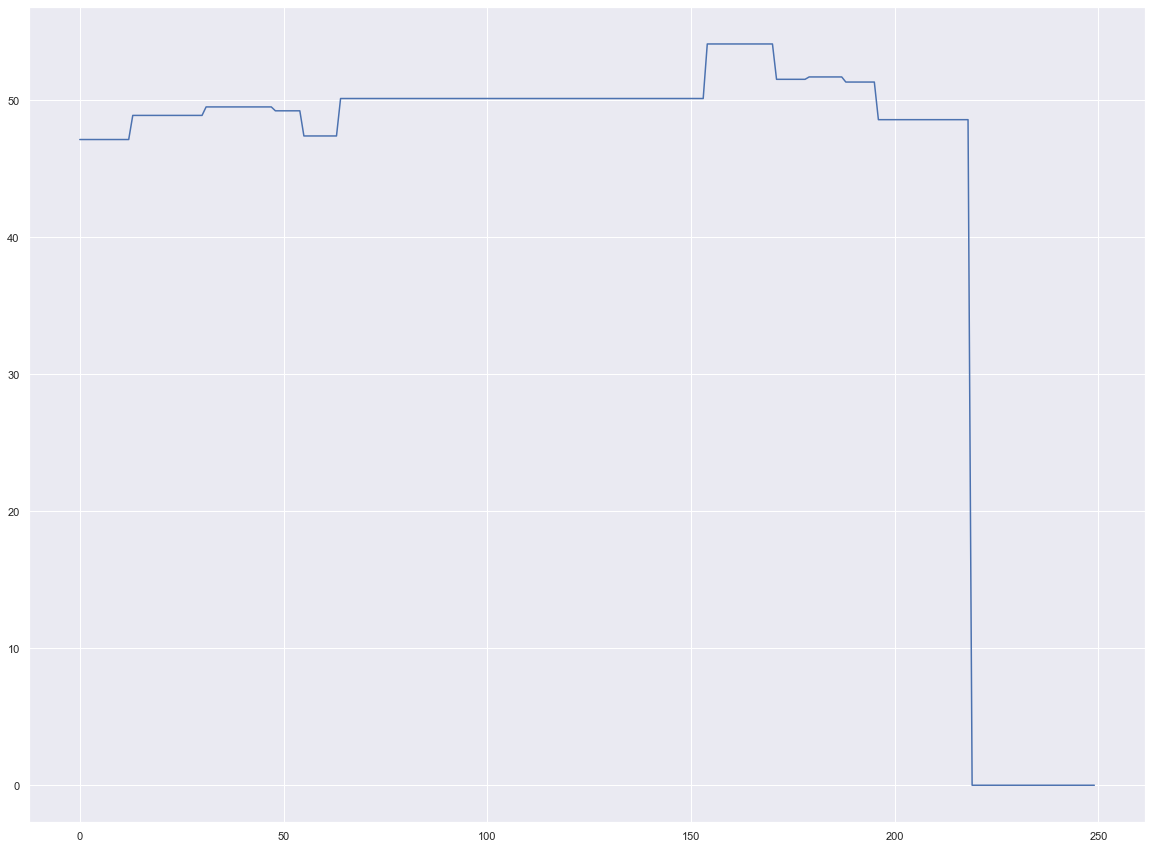

In [31]:
print(db_y[400])
plt.plot(db_x[400])
plt.show()